# Variational Autoencoder - MNIST

Here, in this notebook, we'll see how to create a basic Variational Autoencoder to generate new data for the dataset, we have used Sine function as datasource. 

**NOTE: HERE WE WILL NOT USE THE SINE FUNCTIONS'S DATASET FOR AUTOENCODER TIMESERIES. WE'LL USE IT IN A DIFFERENT LSTM AUTOENCODER.**

The VAEs can be used to generate new data for unbalanced dataset. Just train a VAE with the class with less examples and use the VAE to generate more examples for the class.

Here, in this notebook, we'll use the MNIST dataset to train a VAE and generate new image later.

In [53]:
import torch.nn as nn
import torch
from torch.nn.modules.container import Sequential
from torch.utils.data import TensorDataset, DataLoader,random_split
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision import utils

In [4]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
pass

## Loading or Formulating the dataset
 Using `torchvision` dataset.

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [8]:
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

test_data = datasets.MNIST(root='data', train=False, download=True,  transform=transform)

In [11]:
m=len(train_data)
train_ds, test_ds = random_split(train_data, [int(m-m*0.2), int(m*0.2)])

In [12]:
train_loader = DataLoader(train_ds,128, shuffle=True)
test_loader = DataLoader(test_ds, 128, shuffle=True)

## Modelling

![VAE](helper/vae.png)

A VAE is type of encoder decoder network but unlike autoencoders, the latent vector (the bottle next layer's value) is not some random vector but actually the set of some configuration of mean and variance of the dataset.

This helps us in generating new data with ease as we know from which set to choose the input value (Latent Vector) for the decoder layer.

Watch [this](https://www.youtube.com/watch?v=fcvYpzHmhvA) video for more details on the theory of VAE.

<video src='https://www.youtube.com/watch?v=fcvYpzHmhvA' width=180/>

### **Encoder**

The first part of the an **Variational AutoEncoder** model is the **Encoder**. The Encoder would take image features in this case and layer by layer, it will reduce the size of the features to $128$ points in the end, the size is in the variable `latent_vector_size`.

Here *KL* is the [*KL divergence*](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8)

In [14]:
latent_vector_size = 128

In [15]:

class EncoderNN(nn.Module):

    def __init__(self):

        super(EncoderNN, self).__init__()

        self.conv_1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv_2 = nn.Conv2d(8, 16, 3, stride=2, padding=1) 
        self.batch_1 = nn.BatchNorm2d(16)
        self.conv_3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear_1 = nn.Linear(3*3*32, 128)
        self.linear_2 = nn.Linear(128, latent_vector_size)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
        
    def forward(self, x):
        x = F.relu(self.conv_1(x))        
        x = F.relu(self.batch_1(self.conv_2(x)))

        x = F.relu(self.conv_3(x))

        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.linear_1(x))

        mu = self.linear_2(x)

        sigma = torch.exp(self.linear_2(x))

        z = mu + sigma*self.N.sample(mu.shape)

        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        return z



### **Decoder**

The second part of the an **Variational AutoEncoder** model is the **Decoder**. The Decoder would take it from where Encoder finishes. The Decoder would take the $25$ features here in this case and layer by layer it will increase the size of the features from $128$ to the image size.

So the Decoder again reconstructs the data to the same number of data points form where the Encoder started. We will then use this reconstructed data, compare it with the original data and calculate the loss. The whole idea is to try reduce this error.

In [16]:
class DecoderNN(nn.Module):

    def __init__(self):
        super(DecoderNN, self).__init__()

        self.linear_1 = nn.Linear(latent_vector_size, 128)        
        self.linear_2 = nn.Linear(128, 3*3*32)

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        
        self.conv_T_1 = nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0)
        self.batch_1 = nn.BatchNorm2d(16)
        self.conv_T_2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
        self.batch_2 = nn.BatchNorm2d(8)
        self.conv_T_3 = nn.ConvTranspose2d(8, 1, 3, stride=2,  padding=1, output_padding=1)

    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        x = self.unflatten(x)
        x = self.conv_T_1(x)
        x = F.relu(self.batch_1(x))
        x = self.conv_T_2(x)
        x = F.relu(self.batch_2(x))
        x = self.conv_T_3(x)

        reconstruction = torch.sigmoid(x)
        return reconstruction

In [17]:
class AutoencoderNN(nn.Module):

  def __init__(self):
    super(AutoencoderNN,self).__init__()
    
    self.encoderNN = EncoderNN().to(device)
    self.decoderNN = DecoderNN().to(device)


  def forward(self,x):
    x = self.encoderNN(x)  
    x = self.decoderNN(x)
    return x

In [18]:
model = AutoencoderNN().to(device)
print(model)

AutoencoderNN(
  (encoderNN): EncoderNN(
    (conv_1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear_1): Linear(in_features=288, out_features=128, bias=True)
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (decoderNN): DecoderNN(
    (linear_1): Linear(in_features=128, out_features=128, bias=True)
    (linear_2): Linear(in_features=128, out_features=288, bias=True)
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (conv_T_1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (batch_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_T_2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding

In [19]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [20]:
epochs = 100

running_loss_history = []
epoch_list = []
val_running_loss_history = []

for epoch in range(epochs):

    running_loss = 0.0
    val_loss = 0.0

    # See we're not using any labels here.
    model.train()
    for inputs, _ in train_loader:

        inputs = inputs.to(device)

        optimizer.zero_grad()

        output = model(inputs)

        loss = ((inputs - output)**2).sum() + model.encoderNN.kl

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        model.eval()
        with torch.no_grad():

            for val_inputs, _ in test_loader:

                val_inputs = val_inputs.to(device)

                val_encoded = model.encoderNN(val_inputs)

                val_outputs = model(val_inputs)

                loss = ((val_inputs - val_outputs)**2).sum() + model.encoderNN.kl

                val_loss += loss.item()

                
    if (epoch+1) % 10 == 0:

        running_loss_history.append(running_loss / len(train_loader.dataset))
        
        print('epoch :', (epoch+1))
        print('training loss: {:.4f}'.format(running_loss / len(train_loader.dataset)))
        print('validation loss: {:.4f}'.format(val_loss / len(test_loader.dataset)))
        epoch_list.append(epoch + 1)

        print('_'*20)

epoch : 10
training loss: 106.3354
validation loss: 105.7649
____________________
epoch : 20
training loss: 102.6578
validation loss: 102.5859
____________________
epoch : 30
training loss: 100.8673
validation loss: 100.7539
____________________
epoch : 40
training loss: 99.0219
validation loss: 98.9820
____________________
epoch : 50
training loss: 98.0976
validation loss: 97.9988
____________________
epoch : 60
training loss: 97.6184
validation loss: 97.4893
____________________
epoch : 70
training loss: 97.1604
validation loss: 97.0382
____________________
epoch : 80
training loss: 96.7195
validation loss: 96.8487
____________________
epoch : 90
training loss: 96.6048
validation loss: 96.5122
____________________
epoch : 100
training loss: 96.3098
validation loss: 96.2466
____________________


In [21]:
torch.save(model.state_dict(),"model_100.pth")

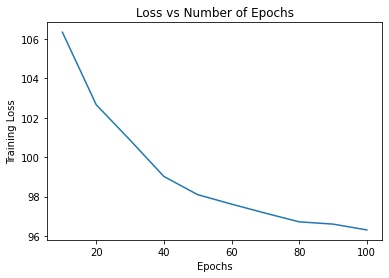

In [22]:
plt.plot(epoch_list,running_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Loss vs Number of Epochs")
plt.show()

### Generating New Data

In [74]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def generate_data():
    latent = torch.randn(1, latent_vector_size, device=device)
    k = model.decoderNN(latent).detach().cpu()
    fig, ax = plt.subplots(figsize=(3, 5))
    show_image(utils.make_grid(k.data[:1],5,5))
    plt.show()

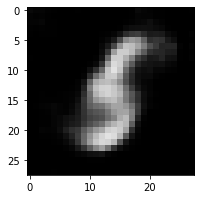

In [76]:
generate_data()

In [78]:
from tqdm import tqdm

encoded_samples = []

for sample in tqdm(test_ds):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    model.eval()
    with torch.no_grad():
        encoded_img  = model.encoderNN(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

100%|██████████| 9600/9600 [00:15<00:00, 629.14it/s]


In [79]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()